In [177]:
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy

#used to hold the position of agents and if they are in posession of a block
class agent:
    def __init__(self, x, y, name, lr, discount):
        #row in world
        self.row = x
        #col in world
        self.col = y
        #holding block
        self.block = False
        # 1 - valid | 0 - invalid
        self.ops = {'north' : 0, 'east' : 0, 'south' : 0, 'west' : 0, 'pick': 0, 'drop': 0}
        #red, black or blue
        self.name = name
        #change made 
        self.qtable = np.zeros((25,2,6), dtype="float")
        self.lr = lr
        self.y = discount
        
    def pick(self):
        self.block = True
    
    def drop(self):
        self.block = False
    
    
    '''
    calculate reward:
    - -1 for ('north', 'west', 'south', 'east')
    - +13 for 'pick' or 'drop'

    returns reward
    '''
    def reward(self, operation):
        if operation in ['north', 'west', 'north', 'east']:
            return -1
        else:
            return 13
        
        
    def moveNorth(self):
         self.row -= 1

    def moveSouth(self):
        self.row += 1

    def moveEast(self):
        self.col += 1

    def moveWest(self):
        self.col -= 1
    '''
    returns the next state if operation is done for traditional q-learning
    '''
    def calculate_new_state(self, operation):
        new_agent = agent(self.row, self.col, self.name, self.lr, self.y)
        if operation == 'north':
            new_agent.moveNorth()
        elif operation == 'south':
            new_agent.moveSouth()
        elif operation == 'east':
            new_agent.moveEast()
        elif operation == 'west':
            new_agent.moveWest()
        elif operation == 'pick':
            new_agent.pick()
        elif operation == 'drop':
            new_agent.drop()

        return new_agent.row, new_agent.col
    
    '''
    reward = +13 or -1
    operation = move made by agent
    '''
    def updateQtable(self, operation, SARSA = False, SARSA_Qval = 0.0):
        reward = self.reward(operation)
        new_row, new_col = self.calculate_new_state(operation)
        new_state = new_row * 5 + (new_col)

        #determine whether agent is holding a block
        holding_block = int(self.block)

        operation_array = list(self.ops.keys())
        old_state = self.row * 5 + (self.col)
        action = operation_array.index(operation)
        # Calculate the maximum Q value for the new state across all possible actions
        max_q_new_state = np.max(self.qtable[new_state, holding_block, :])

       

        if SARSA:
            self.qtable[old_state, holding_block, action] = self.qtable[old_state, holding_block, action] + self.lr * (reward + self.y * SARSA_Qval)
        else:
            # Update the Q value for the old state and action pair using q-learning
            self.qtable[old_state, holding_block,action] = (
                1 - self.lr) * self.qtable[old_state, holding_block, action] + self.lr * (reward + self.y * max_q_new_state)

        if operation == 'north':
            self.moveNorth()
        elif operation == 'south':
            self.moveSouth()
        elif operation == 'east':
            self.moveEast()
        elif operation == 'west':
            self.moveWest()
        elif operation == 'pick':
            self.pick()
        elif operation == 'drop':
            self.drop()


    def visualizeQtable(self):
        # Separate Q-tables based on block status
        qtable_with_block = self.qtable[:, 1, :]  # Q-table where the agent has a block
        qtable_without_block = self.qtable[:, 0, :]  # Q-table where the agent does not have a block

        # Plot Q-table where the agent has a block
        qtable_with_block_df = pd.DataFrame(qtable_with_block)
        plt.figure(figsize=(10, 5))
        plt.title(f'Q-table for {self.name} (with block)')
        sns.heatmap(qtable_with_block_df, annot=True, cmap="YlGnBu")
        plt.show()

        # Plot Q-table where the agent does not have a block
        qtable_without_block_df = pd.DataFrame(qtable_without_block)
        plt.figure(figsize=(10, 5))
        plt.title(f'Q-table for {self.name} (without block)')
        sns.heatmap(qtable_without_block_df, annot=True, cmap="YlGnBu")
        plt.show()



In [178]:

'''
must initialize world with learning rate, discount rate, number of steps, experiment number
sub_experiemnt is only important for Experiment 1
'''

class world:
    def __init__(self, lr, y, episodes, experiment, seed, sub_experiment = 'a'):
        self.environment = np.zeros((5,5), dtype="object")
        self.red = agent(2,2,'red', lr, y)
        self.black = agent(0,2,'black', lr, y)
        self.blue = agent(4,2,'blue', lr, y)
        #order of agents
        self.agents = {'red' : self.red, 'blue' : self.blue, 'black' : self.black}
        #dict to hold pickup and dropoff locations and block numbers
        self.pickLoc = {(0, 4) : 5, (1,3) : 5, (4,1) : 5}
        self.dropLoc = {(0, 0) : 0, (2,0) : 0, (3,4) : 0}
        self.init_environment()
        #learning rate
        self.lr = lr
        #discount rate
        self.y = y
        #episodes
        self.num_episodes = episodes
        self.experiment = experiment
        self.sub_experiment = sub_experiment
        self.terminal_reached = 0
        random.seed(seed)
        self.begin()

    #reset environment if terminal state is reached, called when isTerminal() = True 
    def reset_environment(self):
        for pos in self.pickLoc:
            self.pickLoc[pos] = 5
            

        for pos in self.dropLoc:
            self.dropLoc[pos] = 0
            
        #bring red back to start position
        self.red.row = 2
        self.red.col = 2
        #bring black back to start position
        self.black.row = 0
        self.black.col = 2
        #bring blue back to start position
        self.blue.row = 4
        self.blue.col = 2

    #populate environment
    def init_environment(self):
        for cord, _ in self.pickLoc.items():
            self.environment[cord[0], cord[1]] = 'P'

        for cord, _ in self.dropLoc.items():
            self.environment[cord[0], cord[1]] = 'D'

        for name, agent in self.agents.items():
            self.environment[agent.row][agent.col] = name

    '''
    example code:
    if (agent.col, agent.row) in self.pickLoc.keys():
        self.pickup(agent)

    decreases pickLoc blocks at location of agent and changes agent block state to True
    '''
    def pickup(self, agent):
        #checks if blocks available at 'P' and if agent doesnt have a block
        if self.pickLoc[(agent.row, agent.col)] > 0 and agent.block == False:
            agent.pick()
            self.pickLoc[(agent.row, agent.col)] -= 1
            return True
        
        return False
    '''
    example code:
    if (agent.col, agent.row) in self.dropoff.keys():
        self.dropoff(agent)

    increases pickLoc blocks at location of agent and changes agent block state to False
    '''
    def dropoff(self, agent):
        #checks if current 'D' needs a block and if agent has a block
        if self.dropLoc[(agent.row, agent.col)] < 5 and agent.block == True:
            agent.drop()
            self.dropLoc[(agent.row, agent.col)] += 1
            return True

        return False

    '''
    determines valid operators of agent, part of policy
    '''
    def validOps(self, agent):
        # Reset ops
        agent.ops = {'north': 0, 'east': 0, 'south': 0,
                        'west': 0, 'pick': 0, 'drop': 0}

        other_agents_pos = [(other_agents.row, other_agents.col)
                            for _, other_agents in self.agents.items() if other_agents != agent]

        i, j = agent.row, agent.col
        x = int(agent.block)

        # Conditions for 'north'
        if i > 0 and (i-1, j) not in other_agents_pos:
            agent.ops['north'] = 1

        # Conditions for 'south'
        if i < 4 and (i+1, j) not in other_agents_pos:
            agent.ops['south'] = 1

        # Conditions for 'east'
        if j < 4 and (i, j+1) not in other_agents_pos:
            agent.ops['east'] = 1

        # Conditions for 'west'
        if j > 0 and (i, j-1) not in other_agents_pos:
            agent.ops['west'] = 1

        # Conditions for 'pick'
        if (i, j) in self.pickLoc.keys() and x == 0 and self.pickLoc[(i, j)] > 0:
            agent.ops['pick'] = 1

        # Conditions for 'drop'
        if (i, j) in self.dropLoc.keys() and x == 1 and self.dropLoc[(i, j)] < 5:
            agent.ops['drop'] = 1

    '''
    if picking or dropping a box is available do that, else do random operation

    in the edge case of no valid moves, agent will skip its turn and do nothing
    '''
    def randomOp(self, agent):
        #determine valid operations for the agent
        self.validOps(agent)

        #filter out invalid operations
        valid_operations = [op for op, is_valid in agent.ops.items() if is_valid == 1]

        if len(valid_operations) > 0:
            random_operation = random.choice(valid_operations)
            
            #if drop or pick is available pick that
            if 'pick' in valid_operations and self.pickup(agent):
                random_operation = 'pick'

            elif 'drop' in valid_operations and self.dropoff(agent):
                random_operation = 'drop'

            return random_operation
        
        else:
            return "no valid"
        
    
    '''
    if picking or dropping a box is available do that, else apply operator with highest q-value

    in the edge case of no valid moves, agent will skip its turn and do nothing
    '''
    def greedyOp(self, agent):
        #determines valid operators 
        self.validOps(agent)
        
        #sorts out valid_operations
        valid_operations = [op for op, is_valid in agent.ops.items() if is_valid == 1]
        if len(valid_operations) > 0:
            #need this to access qtable
            ops = ['north', 'south', 'east', 'west', 'pick', 'drop']
            op_to_index = {op: index for index, op in enumerate(ops)}
            block_state = int(agent.block)
            #obtains q-values of valid_operations
            qvalues_of_ops = [agent.qtable[agent.row * 5 + (agent.col), block_state, op_to_index[op]] for op in valid_operations] 
            
            #max q-value within valid_operations
            max = np.max(qvalues_of_ops)
            
            #determine if multiple max qvalues
            max_q_values = [index for index, val in enumerate(qvalues_of_ops) if val == max]

            op = valid_operations[random.choice(max_q_values)]

            if 'pick' in valid_operations and self.pickup(agent):
                op = 'pick'
            
            elif 'drop' in valid_operations and self.dropoff(agent):
                op = 'drop'
                
            return op
        else:
            return "no valid"
        
    '''
    if picking or dropping a box is available to do that, else use coinflip to choose highest operator or random operator
    
    in the edge case of no valid moves, agent will skip its turn and do nothing
    '''
    def exploitOp(self, agent):
        #determine valid operators
        self.validOps(agent)

        #sort out valid_operators
        valid_operations = [op for op, is_valid in agent.ops.items() if is_valid == 1]
        if len(valid_operations) > 0:
            #need this access qtable
            ops = ['north', 'south', 'east', 'west', 'pick', 'drop']
            op_to_index = {op: index for index, op in enumerate(ops)}
            block_state = int(agent.block)
            #obtains q-values of valid_operations
            qvalues_of_ops = [agent.qtable[agent.row * 5 + (agent.col), block_state, op_to_index[op]] for op in valid_operations]

            #max q-value within valid_operations
            max = np.max(qvalues_of_ops)
            
            #determine if multiple max qvalues
            max_q_values = [index for index, val in enumerate(qvalues_of_ops) if val == max]

            coin_toss = random.random()

            #simluate 80 percent vs 20 percent chance
            if coin_toss < 0.80:
                op = valid_operations[random.choice(max_q_values)]
            else:
                op = random.choice(valid_operations)
            
            #if pickup and dropoff is applicable
            if 'pick' in valid_operations and self.pickup(agent):  
                op = 'pick'
            
            elif 'drop' in valid_operations and self.dropoff(agent):
                op = 'drop'
                
            return op
        
        else:
            return "no valid"


    '''
    returns if terminal condition is reached, no boxes in pickup and 5 boxes in each dropoff
    '''
    def isTerminal(self):
        condition = True
        for val in self.pickLoc.values():
            if val != 0:
                condition = False
        
        for val in self.dropLoc.values():
            if val != 5:
                condition = False
        
        return condition
    
    def begin(self):
        count = 0
        order = -1

        while(count < self.num_episodes):
             #order of agents is preserved
            order += 1
            if order > 2:
                order = 0


            #checks if terminal state has been reached
            if self.isTerminal():
                print("Terminal State Reached!")
                self.terminal_reached += 1
                
                #reset order of agents
                order = 0
                self.reset_environment()

            #define current agent to make a step
            agent = list(self.agents.values())[order]
            
            #experiment 1
            if self.experiment == 1:
                
                #run PRANDOM for 500 steps
                if count < 500:
                    operation = self.randomOp(agent)
                    
                    if operation == "no valid":
                        continue
                    agent.updateQtable(operation)

                #part a - keep running PRANDOM
                elif self.sub_experiment == 'a':
                    operation =self.randomOp(agent)
                    
                    if operation == "no valid":
                        continue
                    
                    agent.updateQtable(operation)

                #part b - start running PGREEDY
                elif self.sub_experiment == 'b':
                    operation =self.greedyOp(agent)
                   
                    if operation == "no valid":
                        continue
                    
                    agent.updateQtable(operation)

                #part c - start running PEXPLOIT
                elif self.sub_experiment == 'c':
                    operation = self.exploitOp(agent)
                    
                    if operation == "no valid":
                        continue
                    
                    agent.updateQtable(operation)

            elif self.experiment == 2:
                operation = self.exploitOp(agent)
                
                if operation == "no valid":
                    continue
               
                #obtain agent's new state and next action q_value
                new_agent = copy.deepcopy(agent)
                
                new_row, new_col = agent.calculate_new_state(operation)
                
                new_agent.row = new_row
                new_agent.col = new_col
                
                #new action based off of new state when operation is applied
                new_op = self.exploitOp(new_agent)
                
                #no operation is valid for the "future" movement
                if new_op == "no valid":
                    continue

                new_state = new_row * 5 + (new_col)
                new_block = int(new_agent.block)
                op_list = list(new_agent.ops.keys())
                new_qval = new_agent.qtable[new_state, new_block, op_list.index(new_op)]
                
                agent.updateQtable(operation, True, new_qval)

            elif self.experiment == 4:
                #check if termination 6 is reached
                if self.terminal_reached == 3:
                    self.pickLoc = {(4,2) : 5, (3,3) : 5, (2,4) : 5}

                if self.terminal_reached == 6:
                    break
                
                if count < 500:
                    operation = self.randomOp(agent)
                    
                    if operation == "no valid":
                        continue
                
                    #PRANDOM update
                    agent.updateQtable(operation)
                    
                operation = self.exploitOp(agent)
                    
                if operation == "no valid":
                    continue

                #PEXPLOIT update
                agent.updateQtable(operation)


            
            else:
                print("experiment format not supported")
                break

            #increment count, number of steps, only iterates for valid_operators
            count += 1
            #if count % 100 == 0:
                #agent.visualizeQtable()
            #self.update_environment()
            #self.print_environment()
        
        print(f"box pickup after steps: {self.pickLoc}")
        print(f"box dropoff after steps: {self.dropLoc}")
        print(f"Number of termination steps reached: {self.terminal_reached}")
        for agent in self.agents.values():
            print(agent.visualizeQtable())


### Experiment parameters

'''must initialize world with learning rate, discount rate, number of steps, experiment number
sub_experiemnt is only important for Experiment 1'''

#seeds used for results
seed1 = 3
seed2 = 42

exp_1a = world(0.3, 0.5, 9000, 1, seed1) #experiment 1.a
exp_1b = world(0.3, 0.5, 9000, 1, seed1, 'b') #experiment 1.b
exp_1c = world(0.3, 0.5, 9000, 1, seed1, 'c') #experiment 1.c

exp_2 = world(0.3, 0.5, 9000, 2, seed1) #experiment 2

exp_3 = world(0.15, 0.45, 9000, 1, seed1, 'c') #experiment 3

exp_4 = world(0.3, 0.5, 9000, 4, seed1) #experiment 4

### Run chosen experiment

important information for running code:
- you must use "run all" for code to properly work
- copy and paste the desired experiment from Experiment parameters
- change begin line to pasted experiment variable

Terminal State Reached!
Terminal State Reached!
Terminal State Reached!
Terminal State Reached!
Terminal State Reached!
Terminal State Reached!
Terminal State Reached!
box pickup after steps: {(0, 4): 0, (1, 3): 0, (4, 1): 0}
box dropoff after steps: {(0, 0): 4, (2, 0): 5, (3, 4): 5}
Number of termination steps reached: 7


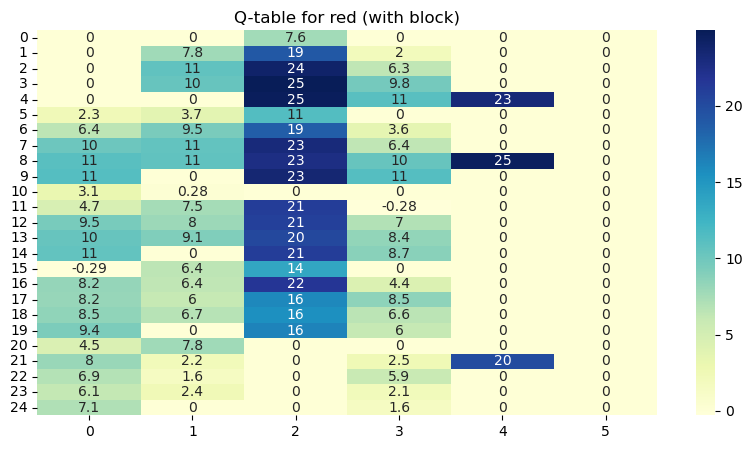

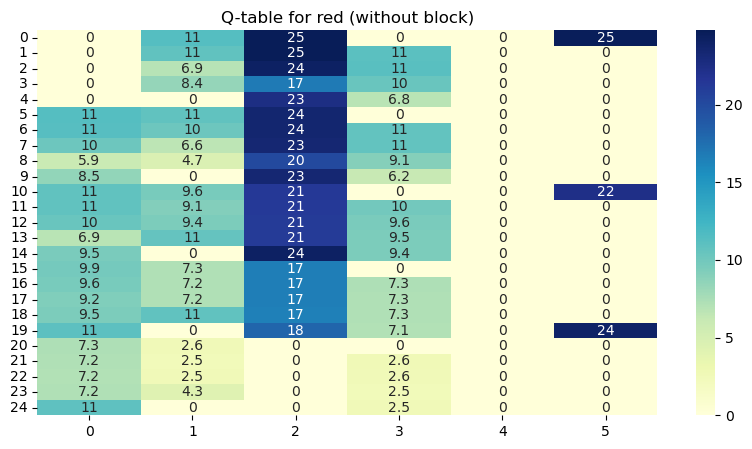

None


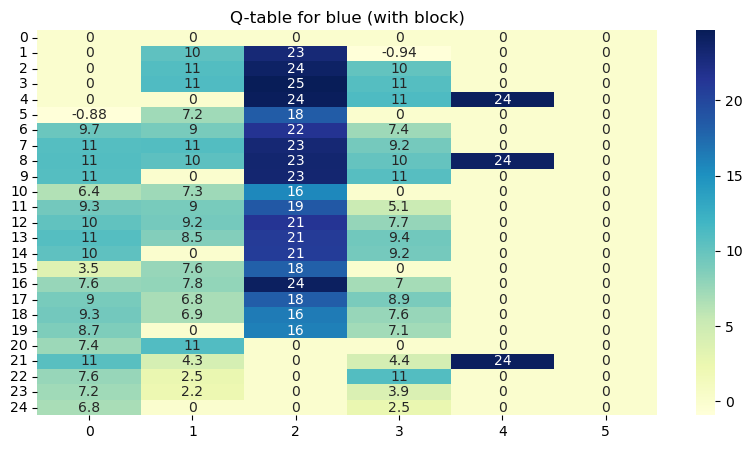

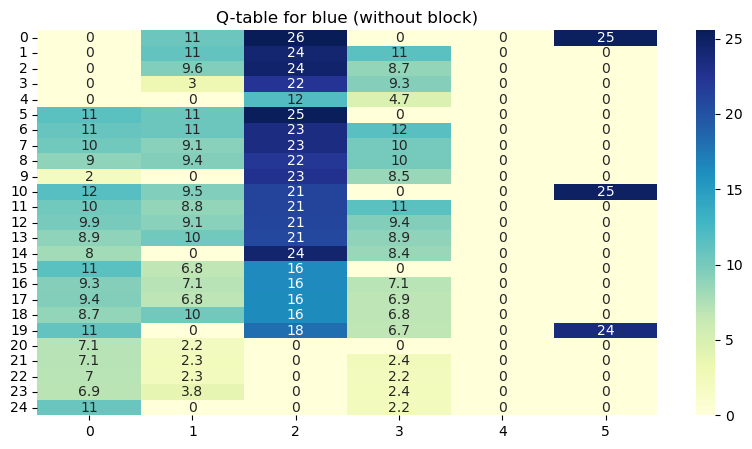

None


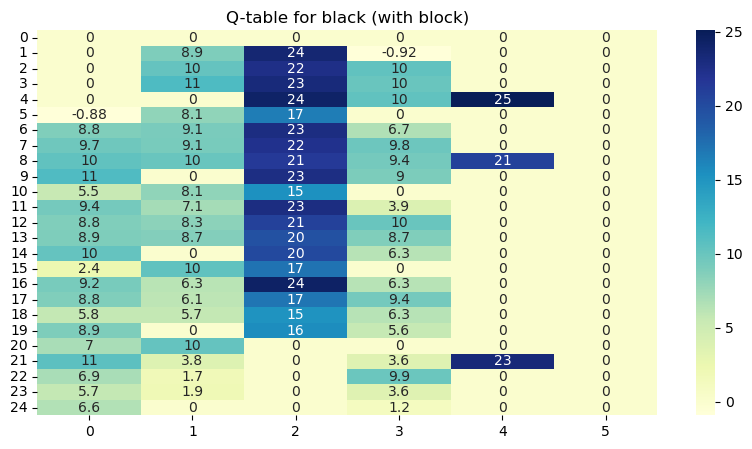

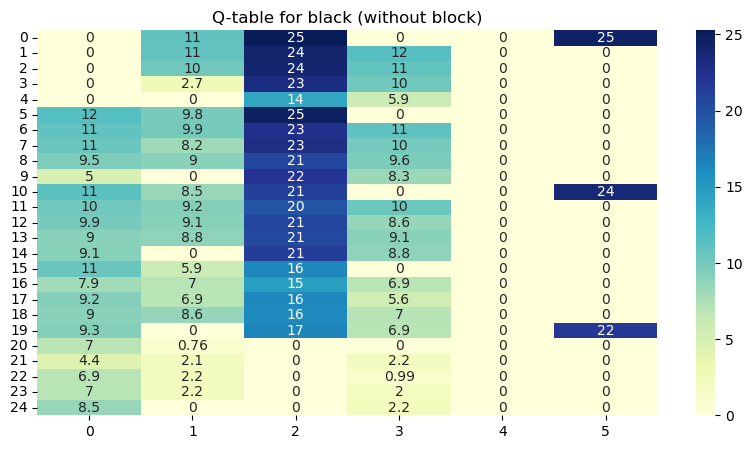

None


In [179]:
exp_1a = world(0.3, 0.5, 9000, 1, seed1) #experiment 1.a